# Koodos  — 2 Moons Dataset

## Overview
In this notebook, we demonstrate the Koodos framework step by step, designed to highlight the core idea behind Koodos: how differential equations can help us solve the problem of continuous temporal domain generalization.

The notebook includes:
1. Load data.
2. Implement Koodos.
3. Train the model.
4. Test the model and visualization.

In [1]:
import math
import copy
import pickle
import numpy as np
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D, art3d
from matplotlib import cm
%matplotlib inline

In [2]:
seed = 1
device = torch.device('cuda:0')
torch.manual_seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

## Step 1: Data Load
We begin by generating the 2-Moons dataset, where the moons rotate continuously over time. The rotation introduces concept drift in the dataset.  
The 2-Moons dataset consists of 50 randomly selected domains over a continuous timeline. Each domain contains 1000 sample points. The first 35 domains are used for training and the last 15 for testing.

#### 1.1 Data Load

In [3]:
def load_datasets(filename="dataset.pkl"):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data["datasets"], data["time_points"]

datasets, time_points = load_datasets('./data/Moons50/dataset.pkl')

#### 1.2 Data Visualization

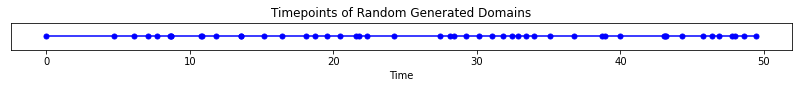

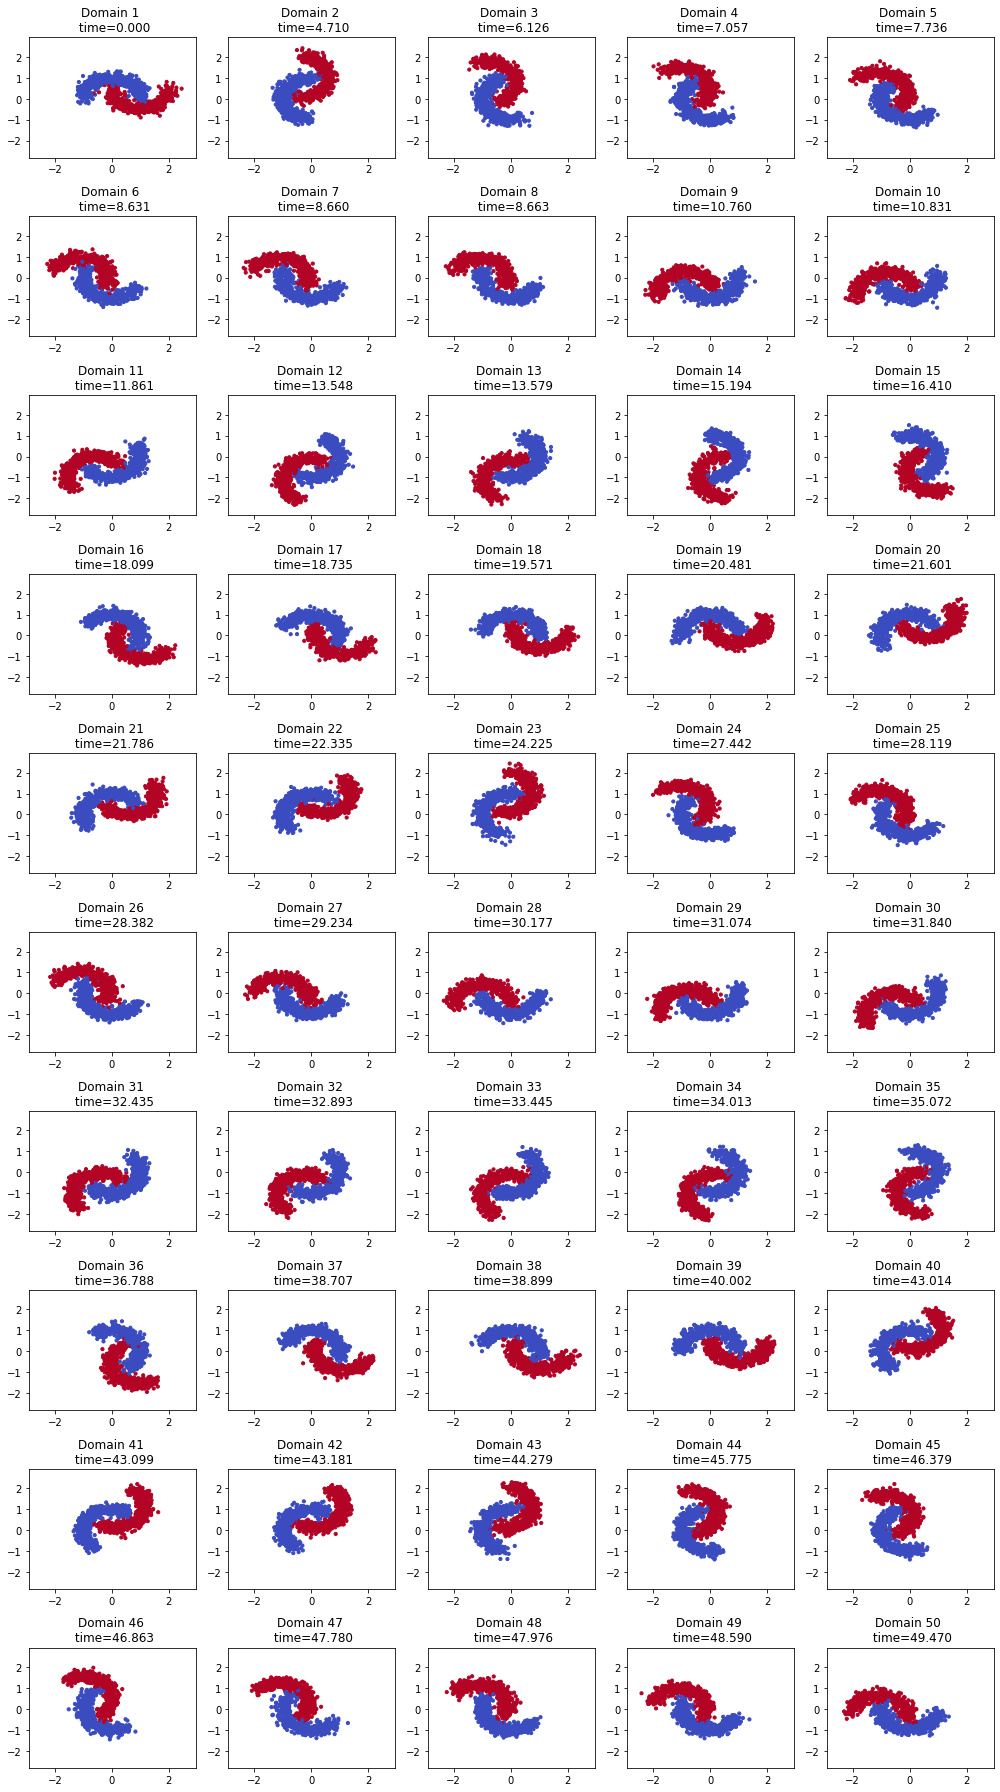

In [4]:
def visualize_moon(datasets, time_points):
    ndomamins = len(time_points)
    ncols = 5
    nrows = math.ceil(ndomamins / ncols)
    
    fig, axs = plt.subplots(figsize=(14, 2.5 * nrows), nrows=nrows, ncols=ncols)
    axs = axs.ravel()

    all_data = np.vstack([data for data, _ in datasets])
    x_min, x_max = all_data[:, 0].min() - 0.5, all_data[:, 0].max() + 0.5
    y_min, y_max = all_data[:, 1].min() - 0.5, all_data[:, 1].max() + 0.5

    for idx, (X_t, y_t) in enumerate(datasets):
        axs[idx].scatter(X_t[:, 0], X_t[:, 1], s=10, c=y_t, cmap="coolwarm")
        axs[idx].set_xlim([x_min, x_max])
        axs[idx].set_ylim([y_min, y_max])
        axs[idx].set_title(f"Domain {idx+1} \n time={time_points[idx]:.3f}")
    plt.tight_layout()
    plt.show()
    
def visualize_time(time_points):
    plt.figure(figsize=(14, 0.5))
    plt.plot(time_points, np.zeros_like(time_points), 'bo-', label="Domains", markersize=5)
    plt.yticks([])
    
    plt.xlabel("Time")
    plt.title("Timepoints of Random Generated Domains")
    plt.show()

visualize_time(time_points)            # visualize moments of randomly selected domains
visualize_moon(datasets, time_points)  # visualize each domain

---

## Step 2: Defining the Koodos

The Koodos framework includes the following key modules:
- **Predictive Models $g(\cdot; \theta_i)$** for each domains that can receive $X_i$ data from dataset and outputs its $Y_i$ label.
- **Encoder $\varphi$ and Decoder $\varphi^{-1}$** that maps the parameters of the Predictive Model to the Koopman Space (KS) and back.
- **Koopman Operator $\mathcal{K}$** that define the dynamics of the parameters of the Predictive Model in KS by a deep neural network.
- **Differential Equation Solver** that computes the integration of dynamics over time to obtain the evolved parameters..

The generalized predictive model parameters $\theta^{j\rightarrow i}_{i}$ for the domain $i$ are derived from the predictive model parameters $\theta_j$ of the domain $j$ ($j<i$) through the following equations:
$$
\begin{align}
z_j &= \varphi(\theta_j) \\
z^{j \rightarrow i}_i &= z_j + \int\nolimits_{t_j}^{t_i} \mathcal{K} z_{\tau} \, d\tau = ODESolve(\mathcal{K}, z_j, t_j, t_i) \\
\theta^{j \rightarrow i}_i &= \varphi^{-1}(z^{j \rightarrow i}_i)
\end{align}
$$

To train Koodos, we need to optimize the following constraints:
- $L_{intri}$: $\theta_i$ works well on domain $i$. 
- $L_{integ}$: generalized $\theta^{j\rightarrow i}_{i}$ works well on domain $i$. 
- $L_{consis}$: generalized $\theta^{j\rightarrow i}_{i}$ and $\theta_i$ are identical.
- $L_{recon}$: $\theta_i$ and $\varphi^{-1}(\varphi(\theta_i))$ are identical.
- $L_{dyna}$: $z^{j \rightarrow i}_i$ and $z_i$ are identical.

### 2.1 Define Koodos's internal functions

including predictive_model; generalized_model; encoder; decoder; dynamic_function

In [5]:
data_dim = 2      # The dimension of the data
gene_dim = 2751   # Raw parameter dimensions of the generalized model
embed_dim = 32    # Embedding dimensions of the generalized model
n_train = 35      # Number of training domains

# Define the Predictive Model, each training domain has a corresponding predictive model
predictive_model = nn.ModuleList([nn.Sequential(
            nn.Linear(data_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1),
            nn.Sigmoid()) for i in range(n_train)])

# Define the Generalized Model, it receives the domain data x and the generalized model parameters,
# then computes the domain data label y.
# The model structure is the same as the predictive model.
def generalized_model(domain_x, domain_param):
    m_1 = domain_param[:data_dim * 50]
    b_1 = domain_param[data_dim * 50:data_dim * 50 + 50]
    m_2 = domain_param[data_dim * 50 + 50:data_dim * 50 + 50 + 50 * 50]
    b_2 = domain_param[data_dim * 50 + 50 + 50 * 50:data_dim * 50 + 50 + 50 * 50 + 50]
    m_3 = domain_param[data_dim * 50 + 50 + 50 * 50 + 50:data_dim * 50 + 50 + 50 * 50 + 50 + 50]
    b_3 = domain_param[-1]

    domain_y = torch.sigmoid(F.linear(torch.relu(F.linear(torch.relu(F.linear(domain_x, m_1.reshape((50, data_dim)), b_1)), m_2.reshape((50, 50)), b_2)), m_3.reshape((1, 50)), b_3))
    return domain_y

# Define the Encoder and the Decoder
encoder = nn.Sequential(
            nn.Linear(gene_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, embed_dim))

decoder = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, gene_dim))

# Define the Koopman Operator
class dyna_f(nn.Module):
    def __init__(self):
        super(dyna_f, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, embed_dim, bias=False))

    def forward(self, t, y):
        return self.net(y)

# Define the ODE Solver, here we choose the fourth-order Runge-Kutta method with a discrete step size of 0.2. 
# A more advanced solver should give better results.
from torchdiffeq import odeint
ode_method = 'rk4'
rk_step = 0.2

> **Tip**: Adding explicit constraints to $\mathcal{K}$ can guide the system toward desired behaviors. Here, if we have a priori knowledge informs us that the concept drift in the data is periodic, then we can configure the $\mathcal{K}$ as $B - B^T$, which will significantly improve the robustness and reliability of the generalized model. To accomplish this uncomment the following code.

In [6]:
# # Define the Koopman Operator with priori knowledge
# class dyna_f(nn.Module):
#     def __init__(self):
#         super(dyna_f, self).__init__()
#         self.L = nn.Parameter(torch.randn((embed_dim, embed_dim)), requires_grad=True)
#         torch.nn.init.xavier_uniform(self.L)

#     def forward(self, t, y):
#         K = self.L - self.L.T
#         return torch.matmul(y, K)

### 2.2 Define the Koodos

In [7]:
# Define the Koodos
class Koodos(nn.Module):
    def __init__(self, time_point):
        super(Koodos, self).__init__()
        self.time_point = time_point

        self.pred_model = predictive_model
        self.gene_model = generalized_model
        self.encoder = encoder
        self.decoder = decoder
        self.dynamic = dyna_f()

    # Obtain prediction and predictive model parameters from each prediction model
    def predictive_model_pred(self, X, idx):
        seg_length = len(X)
        pred, param = [], []
        for i in range(seg_length):
            x = X[i]
            pred.append(self.pred_model[idx + i](x))
            param.append(torch.cat([p.flatten() for p in self.pred_model[idx + i].parameters()]))
        pred, param = torch.cat(pred), torch.stack(param)
        return param, pred

    # Obtain prediction from each generalized model
    def generalized_model_pred(self, X, Gene_Param):
        seg_length = Gene_Param.shape[0]
        pred = []
        for d in range(seg_length):
            x, param = X[d], Gene_Param[d]
            y = self.gene_model(x, param)
            pred.append(y)
        return torch.cat(pred)
    
    def forward(self, X, continous_time=None, idx=0):
        init_param, init_pred = self.predictive_model_pred(X, idx)  # theta_i and predictive model prediction
        init_embed = self.encoder(init_param)  # z_i
        gene_embed = odeint(self.dynamic, init_embed[0], continous_time, method=ode_method, options={'step_size': rk_step})  # z^{j \rightarrow i}_i
        gene_param = self.decoder(gene_embed)  # \theta^{j \rightarrow i}_i
        init_debed = self.decoder(init_embed)  # \varphi^{-1}(\varphi(\theta_j))
        gene_pred = self.generalized_model_pred(X, gene_param)  # generalized model prediction
        return init_pred, gene_pred, init_param, init_embed, init_debed, gene_param, gene_embed

## Step 3: Train the Model



### 3.1 Dataset slice

X is a sequence of domains of length 50, where each element is the data of a domain.  
The shape of X is [50, 1000, 2].  
The shape of Y is [50, 1000, 1].  

In [8]:
# For building the trianing datasets and test datasets
X = torch.Tensor(np.array([item[0] for item in datasets])).to(device)
Y = torch.Tensor(np.array([item[1] for item in datasets]))[:,:,None].to(device)
time_points = torch.Tensor(time_points).to(device)
X_train, X_text, Y_train, Y_test, time_train, time_test = X[:n_train], X[n_train:], Y[:n_train], Y[n_train:], time_points[:n_train], time_points[n_train:]

### 3.2 Constructe temporal domain sequences via sliding windows

To avoid time consumption and cumulative errors in integrating long sequences, we divide the domain sequence into segments by sliding window with no longer than 10 and integrate each segment separately.

Each train_domain_seg is a sequence of domains of length 10.  
seg_time records the timestampt corresponding to each domain in seg_X.  
The last few segments are used for validation.

In [9]:
seg_len = 10
n_val_seg = 5

train_domain_seg = []
for idx in range(n_train - 1):
    l = min(n_train - idx, seg_len)
    seg_time, seg_X, seg_Y = time_train[idx:idx + l], X_train[idx:idx + l], Y_train[idx:idx + l]
    train_domain_seg.append([seg_time, seg_X, seg_Y])

# The last few segments are used for validation
n_seg, n_train_seg = len(train_domain_seg), len(train_domain_seg) - n_val_seg
idx_train_seg = np.arange(n_train_seg, dtype=np.int64)
idx_val_seg = np.arange(n_train_seg, n_seg, dtype=np.int64)

### 3.3 Training

In [10]:
epoch = 300
batch = 5
alpha = 1
beta = 100
gamma = 10
weight_decay = 1e-4

model = Koodos(time_train).to(device)
optimizer = torch.optim.Adam([{'params': model.pred_model.parameters(), 'lr': 1e-2, 'weight_decay': weight_decay},
                              {'params': model.encoder.parameters(), 'lr': 1e-3, 'weight_decay': weight_decay},
                              {'params': model.decoder.parameters(), 'lr': 1e-3, 'weight_decay': weight_decay},
                              {'params': model.dynamic.parameters(), 'lr': 1e-3, 'weight_decay': weight_decay}])

min_val_loss = np.inf
model.train()
for e in range(epoch):
    epoch_loss = 0
    
    for batch_idx in np.array_split(idx_train_seg, n_train_seg // batch):
        loss = 0
        for idx in batch_idx:
            seg_time, seg_X, seg_Y = train_domain_seg[idx]

            init_pred, gene_pred, init_param, init_embed, init_debed, gene_param, gene_embed = model(seg_X, seg_time, idx)

            Y = seg_Y.view(-1, 1)
            loss_intri = F.binary_cross_entropy(init_pred, Y)
            loss_integ = F.binary_cross_entropy(gene_pred, Y)
            loss_recon = F.mse_loss(init_param, init_debed)
            loss_dyna = F.mse_loss(init_embed, gene_embed)
            loss_consis = F.mse_loss(init_param, gene_param)
            loss = loss + alpha * loss_intri + alpha * loss_integ + beta * loss_recon + gamma * loss_dyna + beta * loss_consis

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
        
    val_loss = 0
    for idx in idx_val_seg:
        seg_time, seg_X, seg_Y = train_domain_seg[idx]
        init_pred, gene_pred, _, _, _, _, _ = model(seg_X, seg_time, idx)
        Y = seg_Y.view(-1, 1)
        loss_integ = F.binary_cross_entropy(gene_pred, Y)
        val_loss = val_loss + loss_integ.item()

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())
    
    if e % 20 == 0:
        print('Epoch: {}, Train Loss: {:.5f}, Val Loss: {:.5f}'.format(e, epoch_loss, val_loss))
        
model.load_state_dict(best_model_state)

Epoch: 0, Train Loss: 176.35019, Val Loss: 3.46551
Epoch: 20, Train Loss: 40.09120, Val Loss: 3.16091
Epoch: 40, Train Loss: 29.88815, Val Loss: 3.07299
Epoch: 60, Train Loss: 31.44285, Val Loss: 3.82907
Epoch: 80, Train Loss: 19.07755, Val Loss: 4.72389
Epoch: 100, Train Loss: 11.17587, Val Loss: 0.52081
Epoch: 120, Train Loss: 7.23488, Val Loss: 0.80828
Epoch: 140, Train Loss: 5.92347, Val Loss: 0.30598
Epoch: 160, Train Loss: 3.03979, Val Loss: 0.19411
Epoch: 180, Train Loss: 2.82071, Val Loss: 0.17936
Epoch: 200, Train Loss: 9.72518, Val Loss: 0.26553
Epoch: 220, Train Loss: 2.33775, Val Loss: 0.19575
Epoch: 240, Train Loss: 2.07448, Val Loss: 0.16010
Epoch: 260, Train Loss: 5.46602, Val Loss: 0.54044
Epoch: 280, Train Loss: 1.86803, Val Loss: 0.15740


<All keys matched successfully>

---

## Step 4. Test the Model and Visualization

### 4.1 Calculate the accuracy on the test set

To generalize the generalized parameters of the test domains, we take out the parameters of the last trained predictive model as the start timepoint, and then use odeint() to compute the generalized parameters of each test domain, while later using generalized_model_pred() function to get the results.

In [11]:
# Generalize models fot future test domains from the last training domain
last_param = torch.cat([p.flatten() for p in model.pred_model[-1].parameters()])
last_time = model.time_point[-1:]
final_time_test = torch.cat([last_time, time_test])

last_embed = model.encoder(last_param)
test_embed = odeint(model.dynamic, last_embed, final_time_test, method=ode_method, options={'step_size': rk_step})[1:]
test_param = model.decoder(test_embed)
test_pred = model.generalized_model_pred(X_text, test_param).reshape_as(Y_test)

In [12]:
# Compute the score
test_pred_flatten, Y_flatten = test_pred.view(-1, 1), Y_test.view(-1, 1)
prediction = torch.as_tensor((test_pred_flatten.detach() - 0.5) > 0).float()
accuracy = (prediction.squeeze(-1) == Y_flatten.squeeze(-1)).float().sum() / prediction.shape[0]
print('All Accuracy {:.2%}\n'.format(accuracy))

for i in range(X_text.shape[0]):
    test_pred_step, Y_test_step = test_pred[i], Y_test[i]
    prediction = torch.as_tensor((test_pred_step.detach() - 0.5) > 0).float()
    accuracy = (prediction.squeeze(-1) == Y_test_step.squeeze(-1)).float().sum() / prediction.shape[0]
    print('Step {}, Accuracy {:.2%}'.format(i + 1, accuracy))

All Accuracy 98.86%

Step 1, Accuracy 98.40%
Step 2, Accuracy 99.60%
Step 3, Accuracy 99.30%
Step 4, Accuracy 99.10%
Step 5, Accuracy 98.50%
Step 6, Accuracy 99.10%
Step 7, Accuracy 98.60%
Step 8, Accuracy 98.60%
Step 9, Accuracy 99.30%
Step 10, Accuracy 98.90%
Step 11, Accuracy 98.70%
Step 12, Accuracy 98.90%
Step 13, Accuracy 98.80%
Step 14, Accuracy 99.00%
Step 15, Accuracy 98.10%


### 4.2 Visualize the boundary of the test domain 

Plot the decision boundary of the generalized model for each test domain.

In [13]:
# Define the plotting function
def plot_decision_boundary(model, ax, param, data=None, t=0, ani=False):
    h = .02
    x_min, x_max = -2.5, 2.5
    y_min, y_max = -2.5, 2.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.generalized_model_pred(torch.tensor([np.c_[xx.ravel(), yy.ravel()]], dtype=torch.float32).to(device), param)
    Z = Z.detach().cpu().numpy()
    Z = (Z > 0.5).astype(int)
    Z = Z.reshape(xx.shape)

    if ani:
        im1 = ax.contourf(xx, yy, Z, alpha=0.3)
        im2 = ax.text(1, -2, 'time = {:.2f}'.format(t))
        return im1.collections + [im2]
    else:
        ax.contourf(xx, yy, Z, alpha=0.3)
        ax.contour(xx, yy, Z, levels=[0.5], colors='red', linewidths=2)
        if data:
            X, Y = data
            scatter = ax.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.coolwarm, alpha=0.2)
            
        ax.tick_params(axis='both', which='both', width=2, labelsize=11)
        for spine in ax.spines.values():
            spine.set_linewidth(1.6)

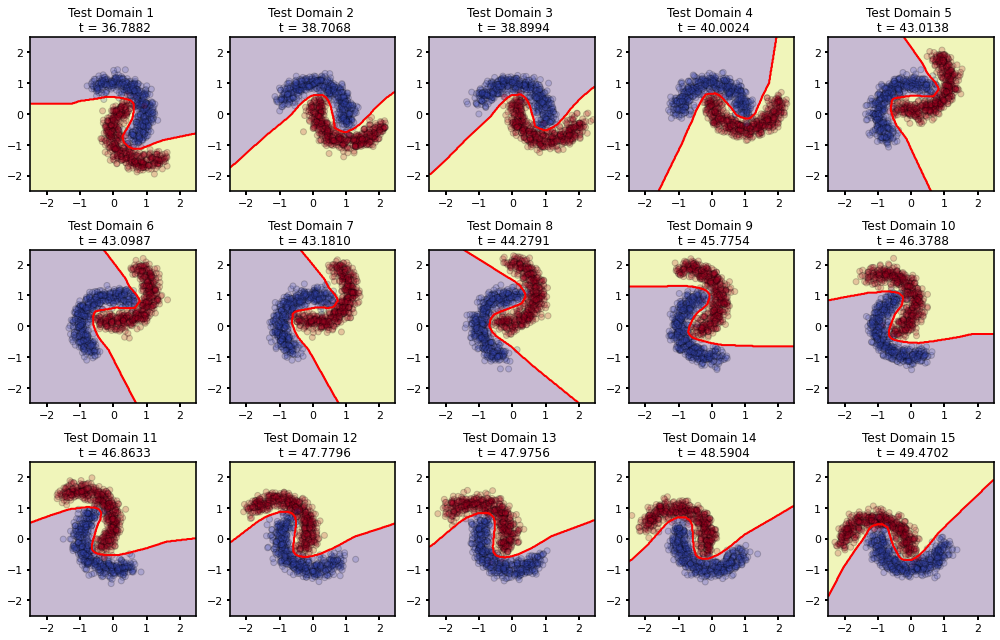

In [14]:
test_tasks = X_text.shape[0]
fig, axs = plt.subplots(math.ceil(test_tasks / 5), 5, figsize=(14, 3 * math.ceil(test_tasks / 5)))
axs = axs.ravel()
for i in range(test_tasks):
    plot_decision_boundary(model, axs[i], test_param[i:i+1], [X_text[i].cpu().numpy(), Y_test[i].cpu().numpy()])
    axs[i].set_title('Test Domain {} \n t = {:.4f}'.format(i+1, time_test[i].item()))
plt.tight_layout()

---

### 4.3 Interpolate and extrapolate fine temporal granularity of model states

Besides testing on the generated test domains (random moment), we can also interpolate and extrapolate the state of the model at **ANY** moment to check the continuity of generalization.

#### 4.3.1. Generate interpolation and extrapolation time points with a step size of 0.2 seconds, using the nearest predictive model of each time point as the starting point.

In [15]:
# Generate Interpolation Timepoints
inter_seg_time = []
insert_time = 0
for idx, i in enumerate(time_train[:-1]):
    seg_time = [time_train[idx].item()]
    while insert_time + rk_step <= time_train[idx + 1]:
        insert_time += rk_step
        seg_time.append(insert_time)
    if len(seg_time) > 1:
        inter_seg_time.append([idx, seg_time])
        
# show some examples
print('The first 4 observation time points:', time_points[:4])
print('Interpolation sequence 1:', [round(x, 4) for x in inter_seg_time[0][1]])
print('Interpolation sequence 2:', [round(x, 4) for x in inter_seg_time[1][1]])
print('Interpolation sequence 3:', [round(x, 4) for x in inter_seg_time[2][1]])
print('......')

The first 4 observation time points: tensor([0.0000, 4.7097, 6.1263, 7.0566], device='cuda:0')
Interpolation sequence 1: [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6]
Interpolation sequence 2: [4.7097, 4.8, 5.0, 5.2, 5.4, 5.6, 5.8, 6.0]
Interpolation sequence 3: [6.1263, 6.2, 6.4, 6.6, 6.8, 7.0]
......


In [16]:
# Generate Extrapolation Timepoints
last_t = model.time_point[-1].item()
seg = [last_t]
for i in np.arange(last_t // rk_step * rk_step + rk_step, 70, rk_step):
    seg.append(i)
extra_seg_time = [[n_train - 1, seg]]

print('The extrapolation time points:', [round(x, 4) for x in extra_seg_time[0][1]])

The extrapolation time points: [35.0722, 35.2, 35.4, 35.6, 35.8, 36.0, 36.2, 36.4, 36.6, 36.8, 37.0, 37.2, 37.4, 37.6, 37.8, 38.0, 38.2, 38.4, 38.6, 38.8, 39.0, 39.2, 39.4, 39.6, 39.8, 40.0, 40.2, 40.4, 40.6, 40.8, 41.0, 41.2, 41.4, 41.6, 41.8, 42.0, 42.2, 42.4, 42.6, 42.8, 43.0, 43.2, 43.4, 43.6, 43.8, 44.0, 44.2, 44.4, 44.6, 44.8, 45.0, 45.2, 45.4, 45.6, 45.8, 46.0, 46.2, 46.4, 46.6, 46.8, 47.0, 47.2, 47.4, 47.6, 47.8, 48.0, 48.2, 48.4, 48.6, 48.8, 49.0, 49.2, 49.4, 49.6, 49.8, 50.0, 50.2, 50.4, 50.6, 50.8, 51.0, 51.2, 51.4, 51.6, 51.8, 52.0, 52.2, 52.4, 52.6, 52.8, 53.0, 53.2, 53.4, 53.6, 53.8, 54.0, 54.2, 54.4, 54.6, 54.8, 55.0, 55.2, 55.4, 55.6, 55.8, 56.0, 56.2, 56.4, 56.6, 56.8, 57.0, 57.2, 57.4, 57.6, 57.8, 58.0, 58.2, 58.4, 58.6, 58.8, 59.0, 59.2, 59.4, 59.6, 59.8, 60.0, 60.2, 60.4, 60.6, 60.8, 61.0, 61.2, 61.4, 61.6, 61.8, 62.0, 62.2, 62.4, 62.6, 62.8, 63.0, 63.2, 63.4, 63.6, 63.8, 64.0, 64.2, 64.4, 64.6, 64.8, 65.0, 65.2, 65.4, 65.6, 65.8, 66.0, 66.2, 66.4, 66.6, 66.8, 67.0,

#### 4.3.2. Define the generalization function and perform interpolation and extrapolation. 

In [17]:
# Define the generalization function: given the starting point (idx) and the desired moment (time_seg), generalize the model
def generalize_model(model, idx, time_seg, return_idx=False):
    idx_param = torch.cat([p.flatten() for p in model.pred_model[idx].parameters()])
    idx_embed = model.encoder(idx_param)
    gene_embed = odeint(model.dynamic, idx_embed, time_seg, method='rk4', options={'step_size': rk_step})
    gene_param = model.decoder(gene_embed)

    s = 0 if return_idx else 1
    return gene_param[s:], time_seg[s:]

In [18]:
# Perform interpolation and extrapolation
inter_param, inter_time = [], []
for idx, time_seg in inter_seg_time:
    time_seg = torch.Tensor(time_seg).to(device)
    gene_param, gene_time = generalize_model(model, idx, time_seg)
    inter_param.append(gene_param)
    inter_time.append(gene_time.cpu().numpy())
inter_param, inter_time = torch.cat(inter_param), np.concatenate(inter_time)

extra_param, extra_time = [], []
for idx, time_seg in extra_seg_time:
    time_seg = torch.Tensor(time_seg).to(device)
    gene_param, gene_time = generalize_model(model, idx, time_seg)
    extra_param.append(gene_param)
    extra_time.append(gene_time.cpu().numpy())
extra_param, extra_time = torch.cat(extra_param), np.concatenate(extra_time)

In [19]:
# Combine interpolation and extrapolation results into genelize_xxx
genelize_time = np.concatenate([inter_time, extra_time])
generalize_param = torch.cat([inter_param, extra_param])

#### 4.3.3. Check generalization results by animation. Results in the *./figure/model_generalization.gif*.

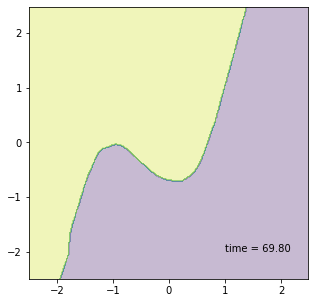

In [20]:
## Plot
figures = []
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
for i in range(len(genelize_time)):
    img = plot_decision_boundary(model, ax, generalize_param[i:i + 1], t=genelize_time[i], ani=True)
    figures.append(img)
ani = animation.ArtistAnimation(fig, figures, interval=100, blit=True, repeat_delay=5000)
ani.save('./figures/model_generalization.gif', writer='pillow')

#### 4.3.4. Check the evolutionary trajectory of the generalized model in the hidden space.

In [21]:
# For getting the model parameters of training domains
train_param = []
for i in range(len(model.pred_model)):
    train_param.append(torch.cat([p.flatten() for p in model.pred_model[i].parameters()]))
train_param, train_time = torch.stack(train_param), model.time_point.cpu().numpy()

In [22]:
# Reduce dimensionality
embed_method = 'tsne'
model_traj = np.concatenate([train_param.detach().cpu().numpy(), inter_param.detach().cpu().numpy(), extra_param.detach().cpu().numpy()], axis=0)
model_traj = TSNE(n_components=2, init='random', random_state=seed).fit_transform(model_traj)

In [23]:
def plot_model_trajectory(ax, model_traj, time):
    train_z, inter_z, extra_z = time
    
    n_train = len(train_z)
    n_inter = len(inter_z)
    n_extra = len(extra_z)
    
    ax.scatter(model_traj[:n_train, 0], model_traj[:n_train, 1], zs=train_z, c='blue', label='Train', s=60)

    inter_points = model_traj[n_train:n_train + n_inter]
    colors = cm.viridis(np.linspace(0, 1, n_inter))
    for i in range(n_inter - 1):
        line = art3d.Line3D([inter_points[i, 0], inter_points[i+1, 0]],
                            [inter_points[i, 1], inter_points[i+1, 1]],
                            [inter_z[i], inter_z[i+1]], 
                            linewidth=3.5, color=colors[i])
        ax.add_line(line)

    extra_points = model_traj[n_train + n_inter:]
    ax.plot(extra_points[:, 0], extra_points[:, 1], 
            zs=extra_z, c='red', linewidth=3.5)

    ax.tick_params(axis='both', which='both', width=2, labelsize=11)
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    ax.tick_params(axis='both', which='major', labelsize=12, width=3, length=6)
    for spine in ax.spines.values():
        spine.set_linewidth(2.0)

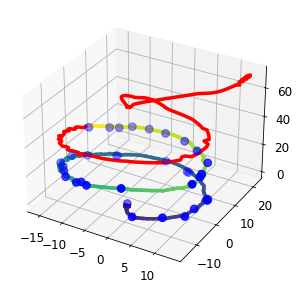

In [24]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
plot_model_trajectory(ax, model_traj, [train_time, inter_time, extra_time])
fig.savefig('./figures/model_trajectory.png', dpi=300, transparent=True)

In [25]:
marker_traj = model_traj[len(train_time):]
cross_marker, = ax.plot([], [], [], 'x', color='red', markersize=14, markeredgewidth=5)

def update(frame):
    cross_marker.set_data(marker_traj[frame, 0], marker_traj[frame, 1])
    z = genelize_time[frame]
    cross_marker.set_3d_properties(z)
    return cross_marker,

ani = FuncAnimation(fig, update, frames=len(marker_traj), interval=100, blit=True, repeat_delay=5000)
ani.save('./figures/model_traj.gif', writer='pillow')